# Predict the quality of outlet of a Distillation Column

## Problem Statement-

The Flash Distillation Column of a Refinery is shown in the diagram embedded below. The effectiveness of industrial distillation tower internals are poorly understood, making first-principles modelling problematic. Traditionally Analyzers are installed to sample and check the quality. But using analyzers is an expensive proposition. We can use AI to predict the resulting purity. In this particular case we have 4 outlet streams, namely 302, 307,313 and 314.

We can use reinforcement learning to optimize a chemical process, in the distillation column. The task for reinforcement learning algorithm will be to learn the optimal control strategy for the distillation column based on the current state and the desired state.

We can then evaluate the performance of the algorithm using metrics such as the total cost, the average cost per unit time, and the stability of the control strategy.

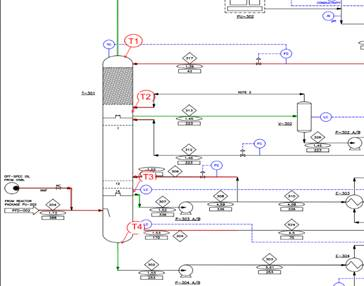

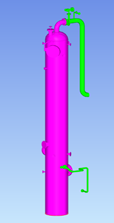

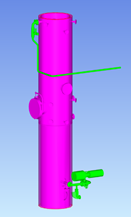

The quality of the streams 302, 307,313 and 314 is directly related to the temperature profile of the column.

## PROPOSED DATA SOURCES

Temperature Data from thermowells T1, T2, T3 and T4 - These will collect data and send it to an IOT device like Raspberry PI or similar.

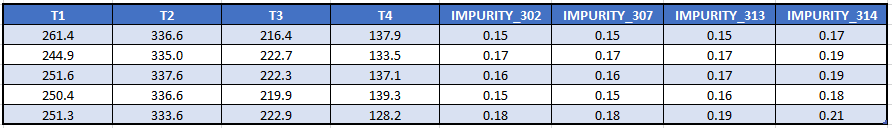

We have generated sample data that is normally distributed about the Temperature of the connected stream. Impurity was generated as some function of T1, T2, T3 and T4.

## Using simple machine learning models

### Import required libraries

In [1]:
#General Libs
import numpy as np
import pandas as pd
import copy
import math
import time
from collections import deque, namedtuple
import random
import os

#EDA and Visualization Libs
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
%matplotlib inline

#Machine Learning Libs
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR


#Reinforcement Learning Libs
import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils
from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.env_checker import check_env

In [2]:
# load the dataset
data = pd.read_excel('DATA.xlsx')
data.head()

,T1,T2,T3,T4,IMPURITY_302,IMPURITY_307,IMPURITY_313,IMPURITY_314
0,261.352051,336.642134,216.433881,137.863700,0.148205,0.146658,0.152516,0.170983
1,244.924264,334.996158,222.691772,133.533230,0.168654,0.166772,0.173676,0.194897
2,251.627350,337.625616,222.318362,137.101125,0.161935,0.160200,0.166657,0.186720
3,250.407605,336.633423,219.915446,139.259344,0.152978,0.151386,0.157394,0.176268
4,251.338720,333.563016,222.854336,128.166120,0.179548,0.177423,0.185060,0.208163


### Exploratory Data Analysis

#### Pair plots

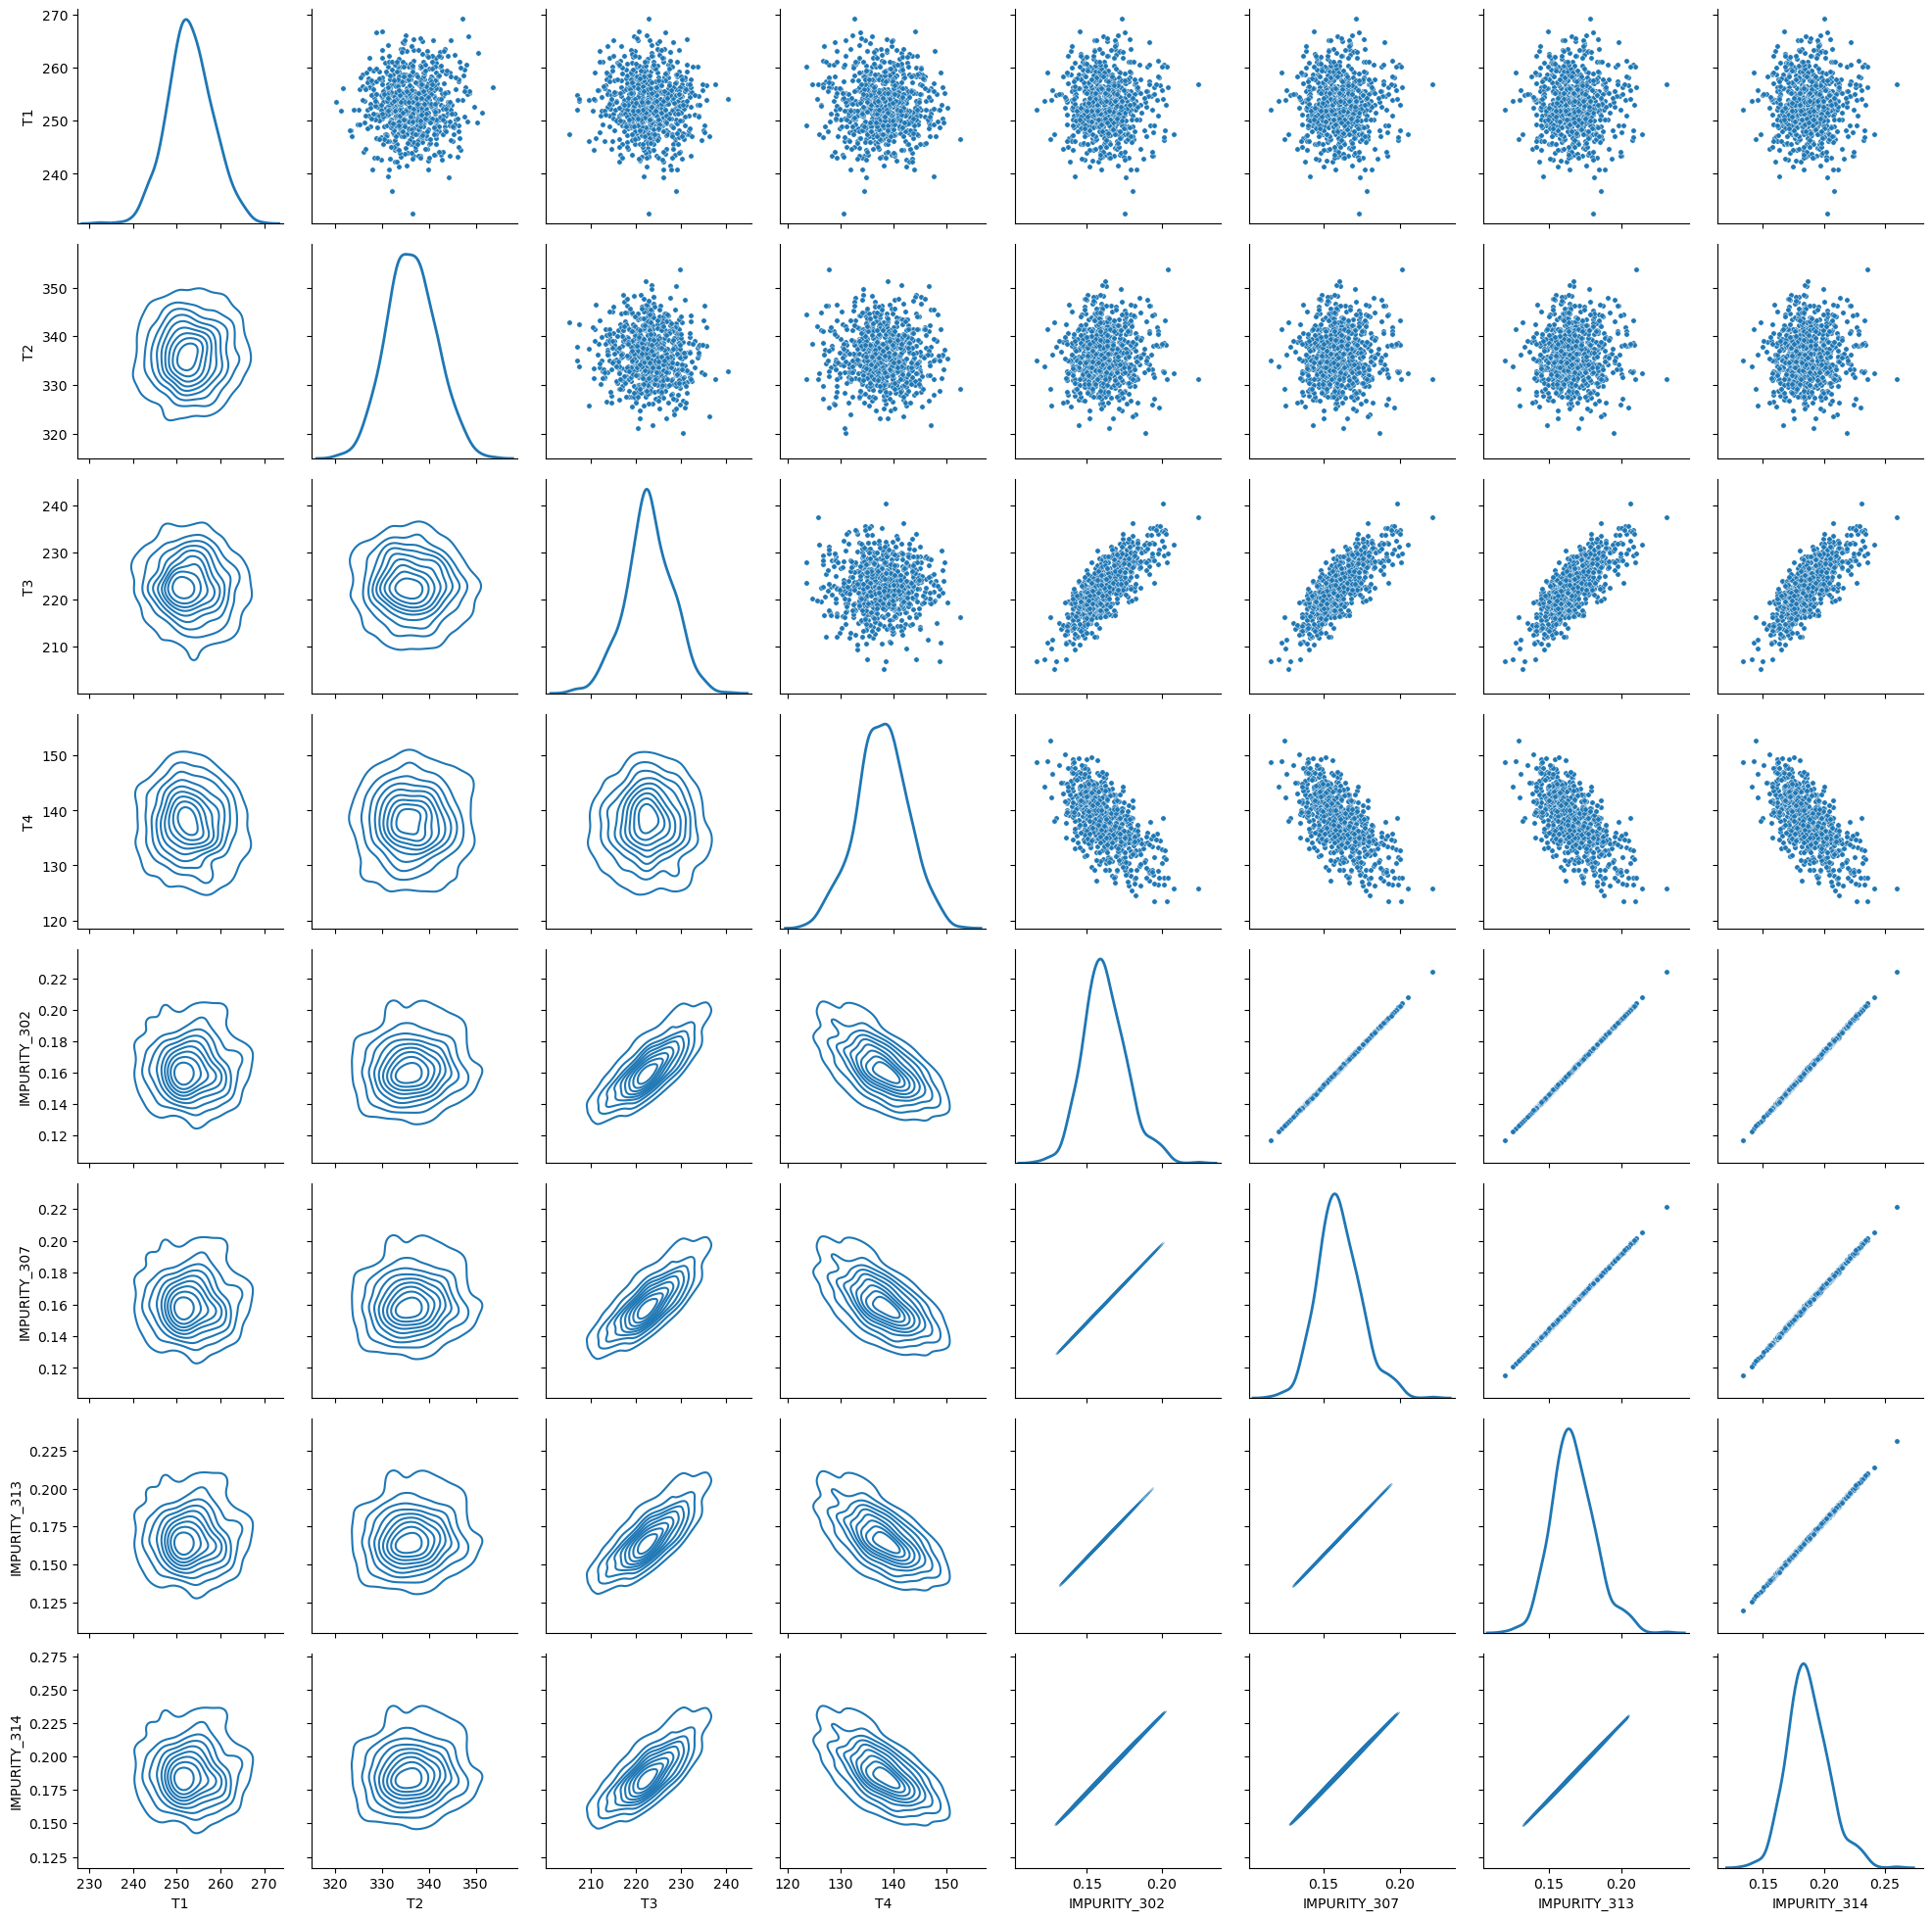

In [3]:
g = sns.PairGrid(data, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

For this study we will concentrate in stream IMPURITY_302. Same can be replicated to IMPURITY_307,	IMPURITY_313,	IMPURITY_314.

In [4]:
data = data.drop(['IMPURITY_307', 'IMPURITY_313', 'IMPURITY_314'], axis=1)
data.head()

,T1,T2,T3,T4,IMPURITY_302
0,261.352051,336.642134,216.433881,137.863700,0.148205
1,244.924264,334.996158,222.691772,133.533230,0.168654
2,251.627350,337.625616,222.318362,137.101125,0.161935
3,250.407605,336.633423,219.915446,139.259344,0.152978
4,251.338720,333.563016,222.854336,128.166120,0.179548


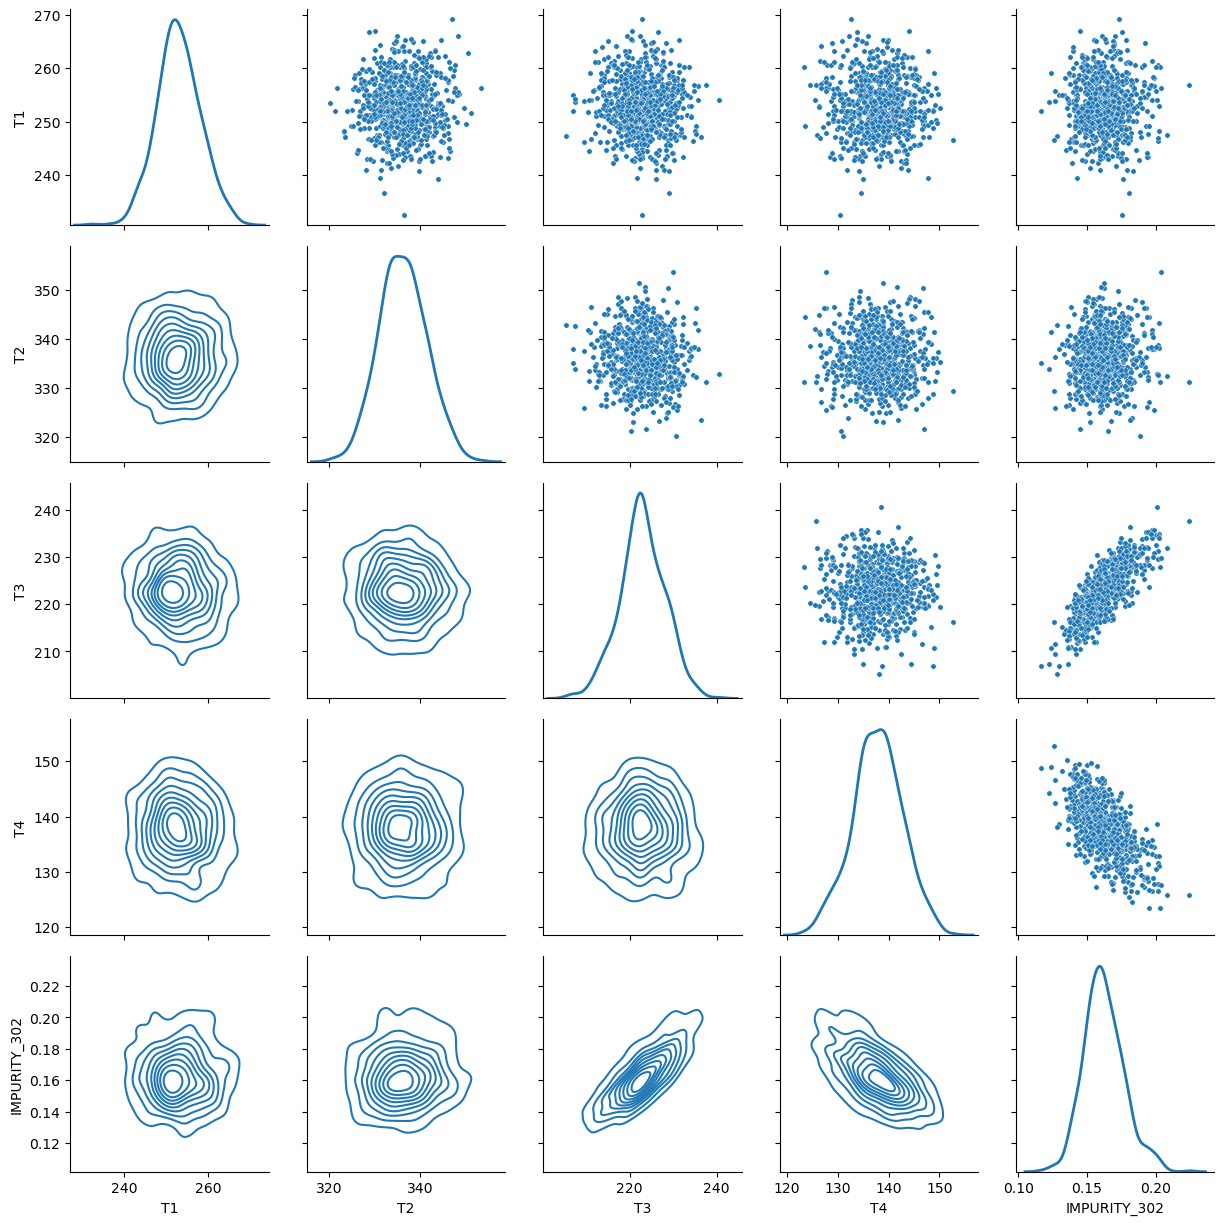

In [5]:
g = sns.PairGrid(data, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

Hypothesis 1: It is evident that for IMPURITY_302, T3 and T4 have better predictive power

#### Correlation Analysis and Feature Selection

In [6]:
pd.options.display.float_format = '{:,.2f}'.format

In [7]:
data.corr()

,T1,T2,T3,T4,IMPURITY_302
T1,1.00,0.04,-0.05,-0.05,-0.01
T2,0.04,1.00,-0.05,-0.01,0.05
T3,-0.05,-0.05,1.00,-0.03,0.79
T4,-0.05,-0.01,-0.03,1.00,-0.63
IMPURITY_302,-0.01,0.05,0.79,-0.63,1.00


In [8]:
#plt.figure(figsize=(16,10))
#sns.heatmap(data.corr(), annot=True)
#plt.show()

This plot validates Hypothesis 1

#### Exploring all predictors

In [9]:
#plt.figure(figsize=(15,5))
#sns.histplot(x='T1',data=data)

#plt.figure(figsize=(15,5))
#sns.histplot(x='T2',data=data)

#plt.figure(figsize=(15,5))
#sns.histplot(x='T3',data=data)

#plt.figure(figsize=(15,5))
#sns.histplot(x='T4',data=data)

#### Exploring Target Variable

<Axes: xlabel='IMPURITY_302', ylabel='Count'>

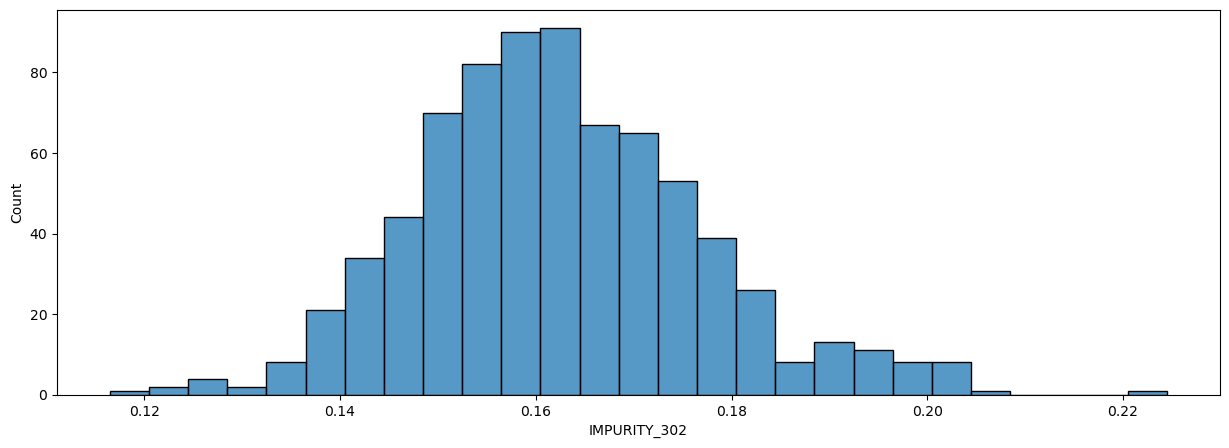

In [10]:
plt.figure(figsize=(15,5))
sns.histplot(x='IMPURITY_302',data=data)

#### Visualizing using scatter plot

Here we will use only two stastistically significant variables, T3 and T4, to get a clean 3D plot

In [11]:
df = data
scat = px.scatter_3d(df, x='T3', y='T4', z='IMPURITY_302',
                    color='IMPURITY_302')
#scat.show()

#Plot and save html
plotly.offline.plot(scat,
                     auto_open=True,
                     filename=("Scatter_Plot_T3_T4_IMPURITY_302.html"))

'Scatter_Plot_T3_T4_IMPURITY_302.html'

# Linear Regression with Scikit-Learn considering only T3

In [12]:
X = data['T3'].values.reshape(-1,1)

In [13]:
y = data['IMPURITY_302'].values

In [14]:
model = LinearRegression()

In [15]:
model.fit(X, y)

LinearRegression()

In [16]:
model.coef_

array([0.00220364])

In [17]:
model.intercept_

-0.3288606720225661

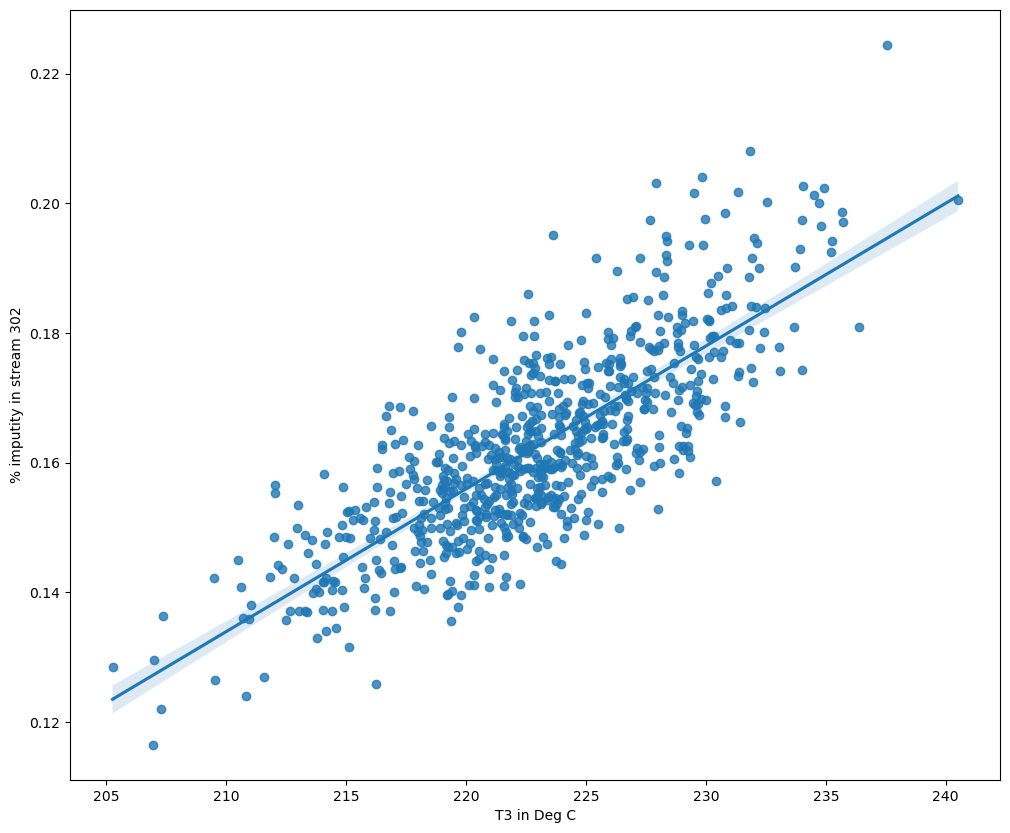

In [18]:
plt.figure(figsize=(12,10));
sns.regplot(x=X, y=y);
plt.xlabel('T3 in Deg C')
plt.ylabel("% imputity in stream 302")
plt.show();

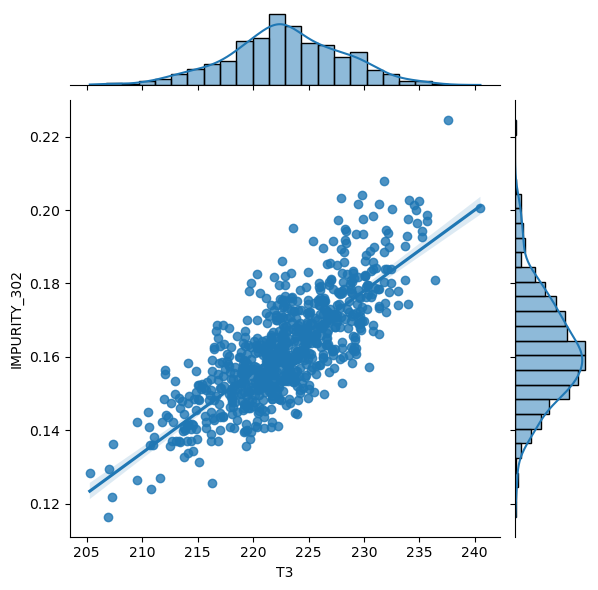

In [19]:
sns.jointplot(x='T3', y='IMPURITY_302', data=data, kind='reg');
plt.show();

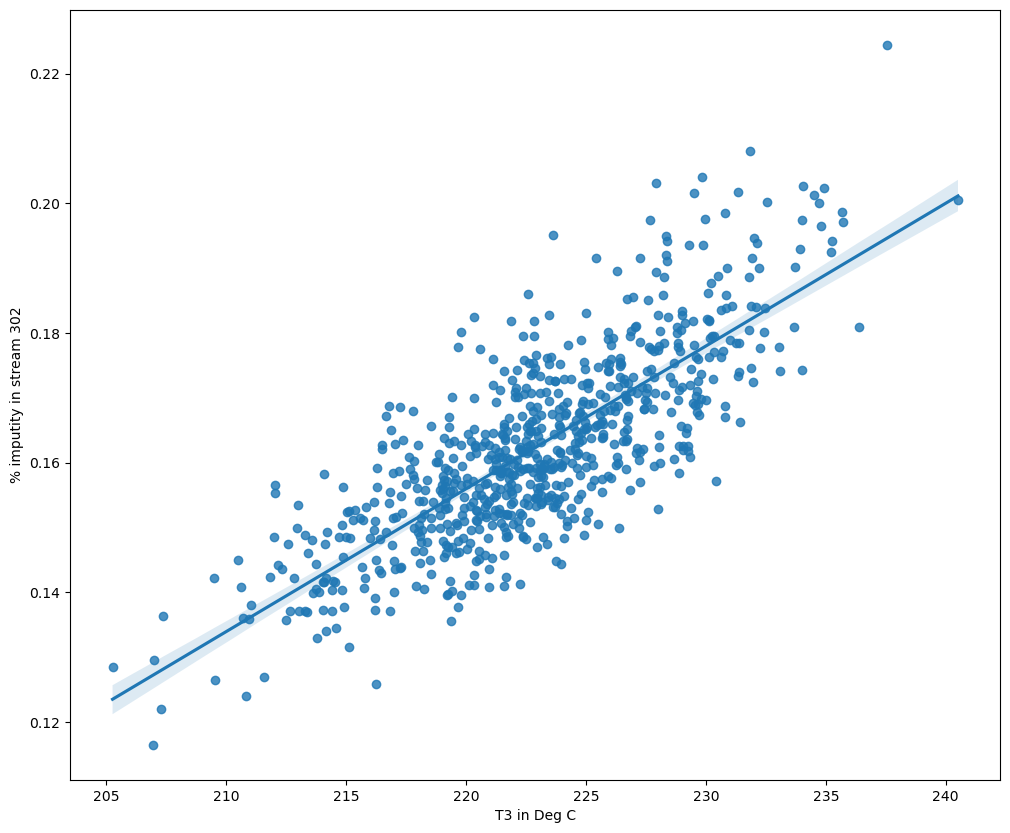

In [20]:
X = data['T3'].values.reshape(-1,1)
y = data['IMPURITY_302'].values
model.fit(X, y)
plt.figure(figsize=(12,10));
sns.regplot(x=X, y=y);
plt.xlabel('T3 in Deg C')
plt.ylabel("% imputity in stream 302")
plt.show();

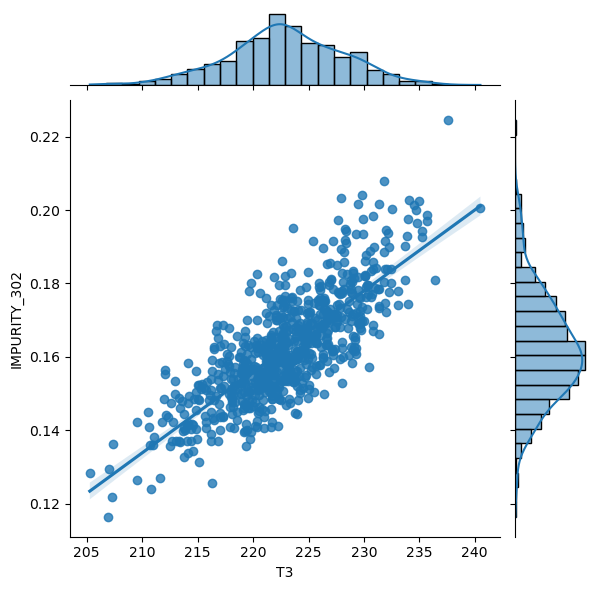

In [21]:
sns.jointplot(x='T3', y='IMPURITY_302', data=data, kind='reg');
plt.show();

# Multi-variable Regression using Variables T3 and T4

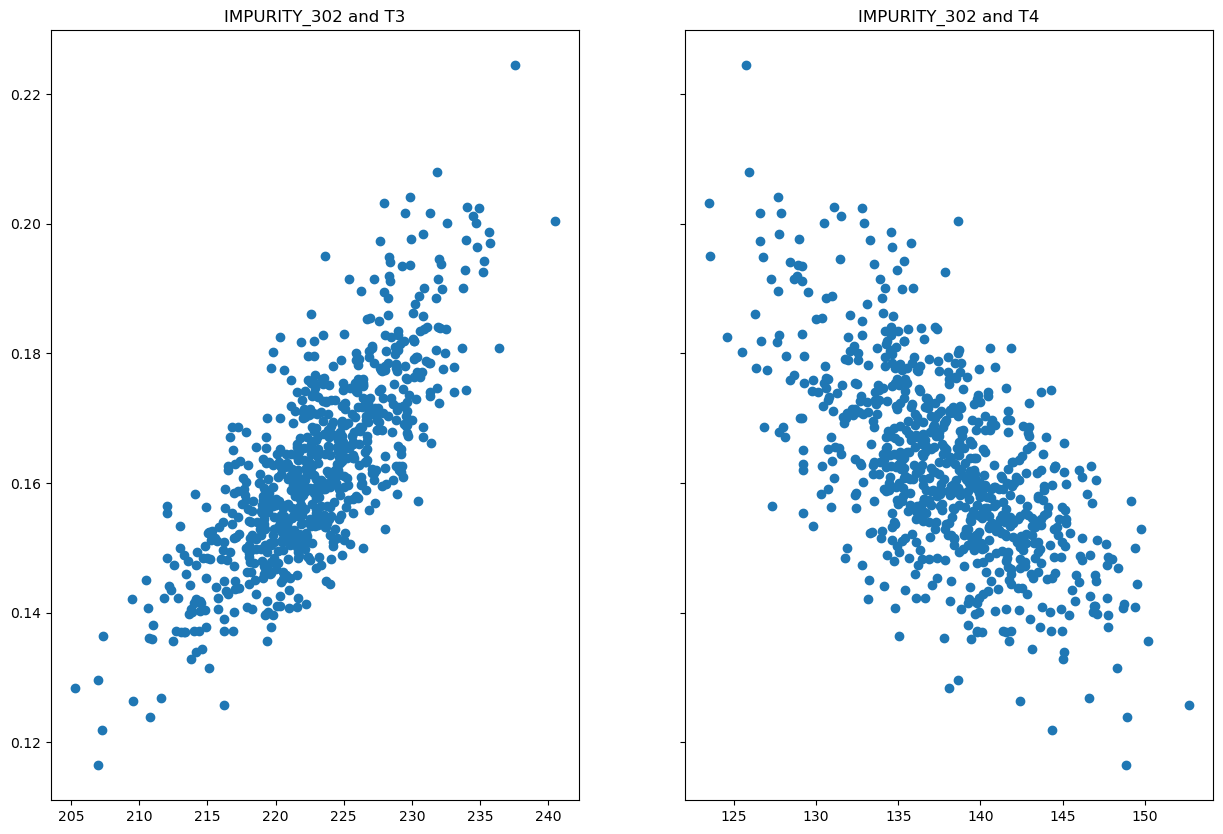

In [22]:
f, (ax3, ax4) = plt.subplots(1, 2, sharey=True, figsize =(15,10)) 

ax3.set_title('IMPURITY_302 and T3')
ax3.scatter(data['T3'],data['IMPURITY_302'])
ax4.set_title('IMPURITY_302 and T4')
ax4.scatter(data['T4'],data['IMPURITY_302'])
plt.show()

C:\Users\aviji\AppData\Local\Temp\ipykernel_21552\3002458016.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='IMPURITY_302', ylabel='Density'>

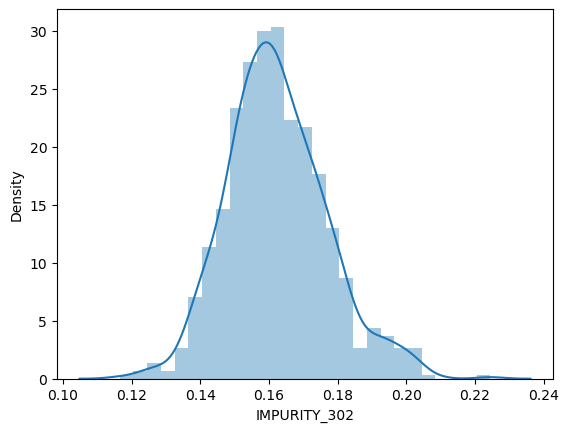

In [23]:
sns.distplot(data['IMPURITY_302'])

In [24]:
targets = data['IMPURITY_302']
inputs = data.drop(['IMPURITY_302','T1','T2'],axis=1)

In [25]:
# Split the variables with an 80-20 split and some random state
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=365) 

In [26]:
# Create a linear regression object
reg = LinearRegression()
# Fit the regression with the scaled TRAIN inputs and targets
reg.fit(x_train,y_train)

LinearRegression()

In [27]:
r_sq = reg.score(x_train,y_train)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {reg.intercept_}")
print(f"coefficients: {reg.coef_}")

coefficient of determination: 0.985594335689964
intercept: -0.07058690276868118
coefficients: [ 0.00215997 -0.00180273]


In [28]:
# Let's check the outputs of the regression
y_hat = reg.predict(x_train)

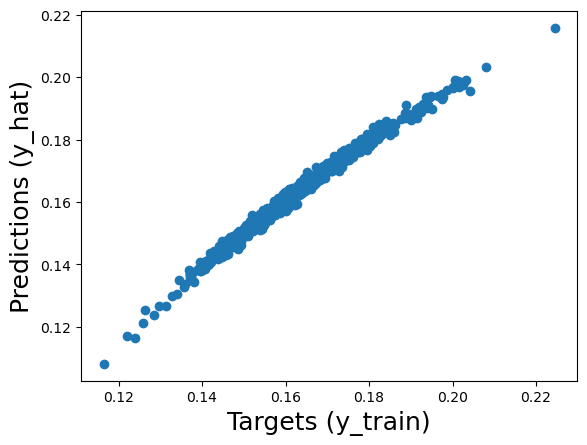

In [29]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot

plt.scatter(y_train, y_hat)

# Let's also name the axes
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.show()

Text(0.5, 1.0, 'Residuals')

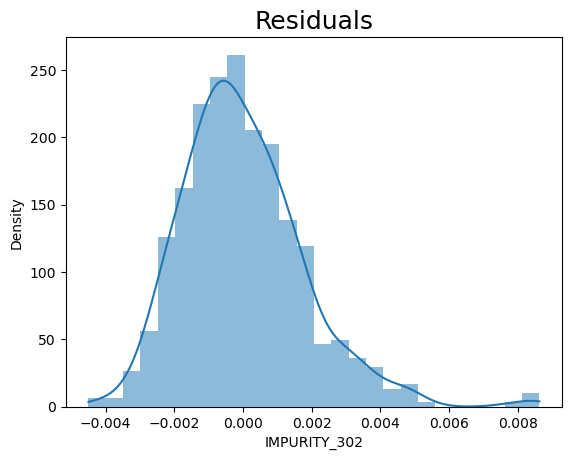

In [30]:
# Another useful check of our model is a residual plot
sns.histplot(y_train - y_hat, kde=True, stat="density", linewidth=0)

# Include a title
plt.title("Residuals", size=18)

In [31]:
# Testing on test set
y_hat_test = reg.predict(x_test)

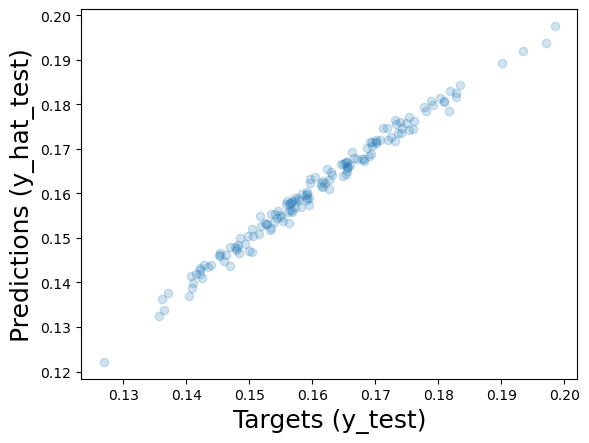

In [32]:
# Create a scatter plot with the test targets and the test predictions

plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)

plt.show()

In [33]:
# Finally, let's manually check these predictions

df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

,Prediction
0,1.17
1,1.19
2,1.15
3,1.17
4,1.20


# Visualizing the Regression considering only T3 and T4

In [34]:
mesh_size = .02
margin = 0

X = data[['T3', 'T4']]
y = data['IMPURITY_302']


# Create a mesh grid on which we will run our model
x_min, x_max = X.T3.min() - margin, X.T3.max() + margin
y_min, y_max = X.T4.min() - margin, X.T4.max() + margin
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)

# Create a linear regression object
reg.fit(X,y)

# Run model
pred = reg.predict(np.c_[xx.ravel(), yy.ravel()])
pred = pred.reshape(xx.shape)

# Generate the plot
fig = px.scatter_3d(data, x='T3', y='T4', z='IMPURITY_302')
fig.update_traces(marker=dict(size=5))
fig.add_traces(go.Surface(x=xrange, y=yrange, z=pred, name='pred_surface'))
#fig.show()

#Plot and save html
plotly.offline.plot(fig,
                     auto_open=True,
                     filename=("RegresssionModel.html"))

C:\Users\aviji\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



'RegresssionModel.html'

# Reinforcement Learning

1. Create Environment
2. Test Environment
3. Train Model
4. Save Model

#### Create Environment

In [35]:
X = data[['T3', 'T4']]
y = data['IMPURITY_302']

from gym import Env
class ColumnEnv(Env):
    def __init__(self):
        # Actions we can take, Open, stay, Close (Regulate a valve)
        self.action_space = Discrete(3)
        # Temperature array
        self.observation_space = Box(low=X.T3.min(), high=X.T3.max())
        self.observation_space = Box(low=X.T4.min(), high=X.T4.max())
        # Set start impurity level
        self.state = y  + random.uniform(-0.1,0.1)
        # Set observation length
        self.observation_length = 60
        
    def step(self, action):
        # Apply action
        self.state += action -1 
        # Reduce observation length by 1 second
        self.observation_length -= 1 
        
        # Calculate reward
        if self.state >=0.00 and self.state <=0.15: 
            reward = 1 
        else: 
            reward = -3 
        
        # Check if observation is done
        if self.observation_length <= 0: 
            done = True
        else:
            done = False
        info = {}
        
        # Return step information
        return self.state, reward, done, info

    def render(self):
        # Implement viz
        pass
    
    def reset(self):
        # Reset purity level;
        self.state = np.array([0.1 + random.uniform(-0.01,0.01)]).astype(float)
        # Reset time
        self.observation_length = 60 
        return self.state

In [36]:
env=ColumnEnv()

In [37]:
env.observation_space.sample()

array([151.96432], dtype=float32)

In [38]:
env.action_space.sample()

2

In [39]:
env.reset()

array([0.10944746])

#### Test Environment

In [40]:
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

Episode:1 Score:-144
Episode:2 Score:-140
Episode:3 Score:-136
Episode:4 Score:-148
Episode:5 Score:-148


In [41]:
#env.close()

#### Train Model

In [42]:
log_path = os.path.join('Training', 'Logs')

In [43]:
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\aviji\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



In [44]:
model.learn(total_timesteps=100000)


Logging to Training\Logs\PPO_11
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 60       |
|    ep_rew_mean     | -154     |
| time/              |          |
|    fps             | 536      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 60          |
|    ep_rew_mean          | -146        |
| time/                   |             |
|    fps                  | 540         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007587624 |
|    clip_fraction        | 0.0542      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.00152     

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 60           |
|    ep_rew_mean          | -26.2        |
| time/                   |              |
|    fps                  | 489          |
|    iterations           | 11           |
|    time_elapsed         | 46           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0151142115 |
|    clip_fraction        | 0.113        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.73        |
|    explained_variance   | 0.000829     |
|    learning_rate        | 0.0003       |
|    loss                 | 46.4         |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.018       |
|    value_loss           | 84.7         |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 60            |
|    ep_rew_mean          | 57.4          |
| time/                   |               |
|    fps                  | 482           |
|    iterations           | 21            |
|    time_elapsed         | 89            |
|    total_timesteps      | 43008         |
| train/                  |               |
|    approx_kl            | 0.00026290206 |
|    clip_fraction        | 0.0061        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0589       |
|    explained_variance   | 0.000458      |
|    learning_rate        | 0.0003        |
|    loss                 | 46.7          |
|    n_updates            | 200           |
|    policy_gradient_loss | -0.000832     |
|    value_loss           | 103           |
-------------------------------------------
-------------------------------------------
| rollout/                |     

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 60           |
|    ep_rew_mean          | 59.3         |
| time/                   |              |
|    fps                  | 475          |
|    iterations           | 30           |
|    time_elapsed         | 129          |
|    total_timesteps      | 61440        |
| train/                  |              |
|    approx_kl            | 0.0008535882 |
|    clip_fraction        | 0.00205      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0212      |
|    explained_variance   | -0.000336    |
|    learning_rate        | 0.0003       |
|    loss                 | 63.1         |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.000285    |
|    value_loss           | 121          |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 60            |
|    ep_rew_mean          | 59.6          |
| time/                   |               |
|    fps                  | 476           |
|    iterations           | 39            |
|    time_elapsed         | 167           |
|    total_timesteps      | 79872         |
| train/                  |               |
|    approx_kl            | 0.00028886038 |
|    clip_fraction        | 0.00083       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0131       |
|    explained_variance   | -1.05e-05     |
|    learning_rate        | 0.0003        |
|    loss                 | 78.2          |
|    n_updates            | 380           |
|    policy_gradient_loss | -0.000212     |
|    value_loss           | 125           |
-------------------------------------------
--------------------------------------------
| rollout/                |    

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 60            |
|    ep_rew_mean          | 59.7          |
| time/                   |               |
|    fps                  | 481           |
|    iterations           | 48            |
|    time_elapsed         | 204           |
|    total_timesteps      | 98304         |
| train/                  |               |
|    approx_kl            | 1.7889834e-06 |
|    clip_fraction        | 0.000195      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.007        |
|    explained_variance   | 1.67e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 61.4          |
|    n_updates            | 470           |
|    policy_gradient_loss | 1.16e-05      |
|    value_loss           | 121           |
-------------------------------------------
------------------------------------------
| rollout/                |      

#### Save Model

In [45]:
model.save('PPO')

In [46]:
evaluate_policy(model, env, n_eval_episodes=100, render=False)

C:\Users\aviji\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.

C:\Users\aviji\anaconda3\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



(60.0, 0.0)

In [47]:
del model